In [20]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets

from classifiers.NerveNet_NU_reduced import NerveNET, BinaryOut
from data_utils_NerveNet_NU import SegmentationData
from solver_NerveNet_NU import Solver
import transform_utils_NerveNet as tu
from dice_loss_NU import DiceLoss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define and Divide Dataset
The following calculates the **sizes of train, validation and test set**. Make sure it returns **True** by modifying the values in the dictionary 'nums'.

In [21]:
img_files = 'image_files.txt' 
num_lines = sum(1 for line in open(img_files, 'r'))
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+2,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 1278, 'num_val': 425, 'num_test': 425} 2128
True


### Initialize Transformations, Train and Validation Dataloader
**New in dataloader**: 
1. New flag for dataloader **binary_out**. If True, it will return a binary value that is if a nerve mask is contained in the target or not. Calling e.g. train_data[0] will return inputs and targets, where targets is now a dictionary with keys **'main'** and **'binary'**, if binary_out is True.
2. New flag for dataloader **mask_only**. If True, the dataloader will return only images that contain a mask. Default is False.
3. The text file that contains the image id's can now be in the git project directory.

In [30]:
input_dim = (1, 32, 32)
#be aware about how these are set
binary_out = True 
mask_only = False 

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])


train_data = SegmentationData(img_files, transform = train_transforms, mode = 'train', **nums, 
                              binary_out = binary_out, mask_only = mask_only)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=10,
                                           shuffle=True,
                                           num_workers=4)

val_data = SegmentationData(img_files,  transform = val_transforms, mode = 'val', **nums)
val_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=10,
                                           shuffle=True,
                                           num_workers=4)

#### Plot Image

1_119.tif


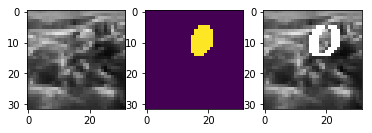

In [31]:
train_data.show_image(2)

### Initialize, Load and Manipulate Classifier

**New in classifier**: 
1. NerveNet has a new **binary_out** flag, too. If True, the forward pass will calculate a binary output. Similarly the output of the forward pass is a dictionary with keys 'main' and 'binary'.
2. The argument **upsample_unit** is a switch between simple upsampling with bilinear interpolation and transposed convolutional layers. Must be either **'Upsample'** or **'ConvTranspose2d'**. Default is 'Upsample'.
3. **Xavier Normal Initialization** is automatically applied to all NerveNet layers if initialized for the first time.

In [47]:
num_classes = 2
model = NerveNET(input_dim, num_classes = num_classes, weight_scale = 0.01, dropout = 0.05, 
                binary_out = binary_out, upsample_unit='Upsample')
#model = torch.load("models/NerveNet_NU_2class.model")
#model.binary_out = True

In [34]:
#Switch between main and binary classification by freezing weights
for param in list(model.parameters()): '''True/False for all layers'''
    param.requires_grad = True

for param in list(model.binary.parameters()): '''True/False for binary output layers'''
    param.requires_grad = False

### Train Classifier

#### Strategy Proposal
##### 1. Train Nervenet without binary influence on dataset that contains only masked images.
Therefore, freeze all weights of model.binary and set train_data argument mask_only to true. The idea behind this is that the encoding stage can properly find filters for detecting nerves. You can set binary_out flag to zero for dataloader, solver and classifier but make sure to enable it for the second stage.
##### 2. Train binary output stage on full dataset.
Therefore, freeze all weights **except** those of model.binary and load set mask_only argument of dataloader to False. Now, the binary output stage is supposed to learn - on basis of the pretrained filters - which image contains a nerve and which does not.
The dataset contains approximateley 75% unmasked images and 25% masked images. Therefore, the accuracy on the binary classification should increase significantly beyond 75%. The classweights for DiceLoss give acces to finetuning the binary probabilities as described below. Since most of the layers are frozen and the memory requirements decrease for this part, you can consider training on a higher batchsize.
##### 3. Compare if binary output gives reasonable classification. 
Therefore, check out the cell with the heading **Visualize**.

Other possibilities:
1. Train on both losses at the same time. The binary_out argument value for the solver is then the influence of the binary loss, as described below.
2. Set num_classes to 1: the output will be a probability image. This would require thresholding.
3. Try different batch_sizes, learning_rates, classweights.
4. ...

Not possible, feel free to implement:
1. Everything is only tested on DiceLoss. Since DiceLoss is loss function and accuracy calculation at the same time, for a native pytorch loss function (if it would work) the accuracy value is not comparable.
2. Automatic saving of the best model. Could be implemented in Solver.validation. 
3. ...

**New in solver**:
1. Solver exspects new **binary_out** argument. Here, it should be a float value, that gives the weight of the loss of the binary output. The main output is implicitly weighted with one, so that **binary_out** should be **smaller than one**. If **binary_out** is equal to **zero**, **no binary loss** will be computed.
2. Train and validation are two seperate functions which seems to be more memory efficient and clearly structured.
3. Printing loss and accuracy were wrapped in seperate functions, too, to further enhance readability of the code.

**New in DiceLoss**:
1. DiceLoss now calculates and automatically detects the loss on **doubleclass input** (Batchsize, Classes = 2, H, W) with single class target (Batchsize, Classes = 1, H, W) by inverting the target for Class = 0 and adding losses for both classes.
2. The argument **classweights** receives weights for losses from class 0 and class 1, respectively. Default is [1, 1]. Try using **[0.01, 0.99]** (from label ratios over the dataset) for training the **main output classification** and **[0.25, 0.75]** (from nerve or no nerve ratios over the dataset) for training the **binary output classification**.
3. **Singleclass input** unstable because some weird increase in memory usage while validation. Maybe the Sigmoid function is unstable? Better initialize model with **num_classes = 2**.



In [35]:
solver = Solver(optim_args={"lr": 0.0005, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = DiceLoss(num_classes = num_classes, classweights = [0.25, 0.75]), binary_out = 1,
                num_classes = num_classes)


model.train()
outputs = solver.train(model, train_loader, val_loader, log_nth=10, num_epochs=5)

START TRAIN.
|Iteration 10/640| TRAIN loss: 1.328
|Iteration 20/640| TRAIN loss: 1.328
|Iteration 30/640| TRAIN loss: 1.245
|Iteration 40/640| TRAIN loss: 1.355
|Iteration 50/640| TRAIN loss: 1.352
|Iteration 60/640| TRAIN loss: 1.222
|Iteration 70/640| TRAIN loss: 1.322
|Iteration 80/640| TRAIN loss: 1.279
|Iteration 90/640| TRAIN loss: 1.309
|Iteration 100/640| TRAIN loss: 1.308
|Iteration 110/640| TRAIN loss: 1.247
|Iteration 120/640| TRAIN loss: 1.283
|Epoch 1/5| TRAIN BINARY acc: 0.751
|Epoch 1/5| TRAIN acc: 0.769
|Epoch 1/5| VAL BINARY acc: 0.710
|Epoch 1/5| VAL acc: 0.773
|Iteration 138/640| TRAIN loss: 1.357
|Iteration 148/640| TRAIN loss: 1.288
|Iteration 158/640| TRAIN loss: 1.327
|Iteration 168/640| TRAIN loss: 1.268
|Iteration 178/640| TRAIN loss: 1.337
|Iteration 188/640| TRAIN loss: 1.303
|Iteration 198/640| TRAIN loss: 1.216
|Iteration 208/640| TRAIN loss: 1.301
|Iteration 218/640| TRAIN loss: 1.384
|Iteration 228/640| TRAIN loss: 1.286
|Iteration 238/640| TRAIN loss: 1.

In [36]:
#Save model 
model.save("models/NerveNet_NU_2class.model")

Saving model... models/NerveNet_NU_2class.model


### Test your Model

In [37]:
#Initialize Dataloader
test_data = SegmentationData(img_files,  transform = val_transforms, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

#### Plot Single Image

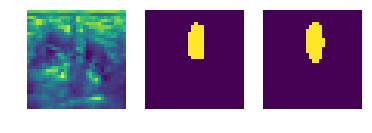

In [44]:
model.eval()

img, targets = test_data[99]

target = targets['main']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs['main']
_, pred = torch.max(pred, 1)
binary_probs, binary = torch.max(outputs['binary'], 1)

#Comment/Uncomment to enable/disable binary classication
if binary.data.numpy() == 0:
    pred = pred * 0
    
pred = pred.squeeze().data.cpu().numpy()
img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(pred)
ax[2].axis('off')
plt.show()

#### Are the binary probabilites making sense?
I found it was quite balanced if both values were around 50%. Therefore, train with classweights = [0.25, 0.75] for 5 epochs at least.

In [39]:
outputs['binary']

Variable containing:
 0.7744  0.2256
[torch.FloatTensor of size 1x2]

### Visualize many Images

Set num_example_imgs to whatever you want and modify the slice in test_data[from:to] accordingly.

#### ToDo:
1. Border overlay of mask over image.
2. Filter plots, weights dreaming.
3. ...


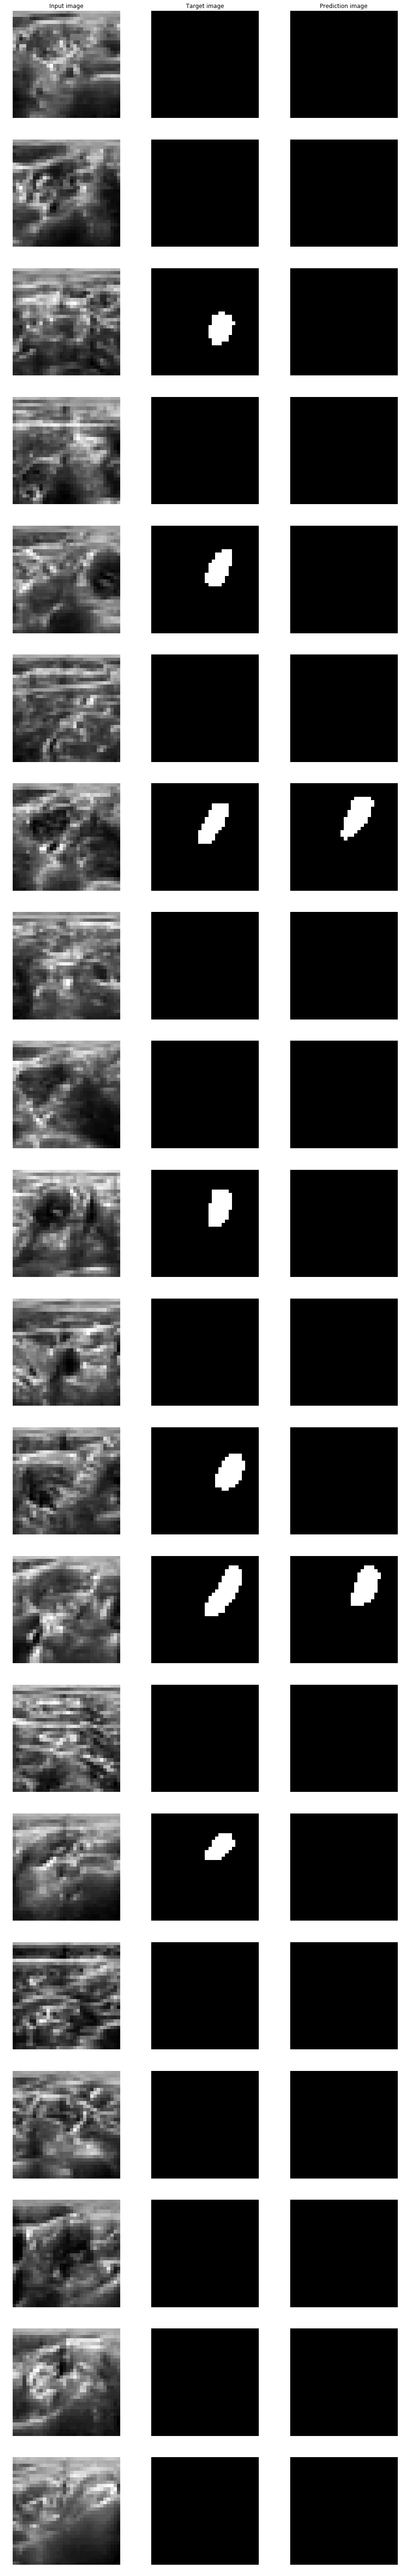

In [41]:
num_example_imgs = 20
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[20:40]):
    
    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    binary_probs, binary = torch.max(outputs['binary'], 1)
    
    #If binary predicts no nerve we just multiply the predicted image with zeros.
    #Comment/Uncomment and plot to compare with/without of binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
        
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

### Dice Coefficient on Testdata

In [42]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p) + np.sum(gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['main'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    
    #Comment/Uncomment to compare with and without binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
    
    pred = pred.squeeze().data.cpu().numpy()
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), pred))
    
np.mean(test_scores)

0.79347253784230121

#### Highscore: score and indice of the best predicted image (with nerve).

In [43]:
x = np.array(test_scores)
x[x==1] = 0
np.max(x), np.argmax(x)

(0.9285714285714286, 99)

#### Other Stuff
Calculation of ratios in datasets (interesting for balancing class weights)

In [45]:
#Total ratio of pixels without/with nerve in dataset
N = 0
mask = 0
for _, (img, target) in enumerate(test_data):
    N += target['main'].numel()
    mask += target['main'].sum()
1 - mask/N, mask/N

(0.9841314338235294, 0.01586856617647059)

In [46]:
#Total ratio of images without/with nerve in dataset
mask = 0
for _, (img, target) in enumerate(test_data):
    mask += target['main'].sum()>0
1 - mask/len(test_data), mask/len(test_data)

(0.7152941176470589, 0.2847058823529412)